In [1]:
import sys
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from IPython.display import HTML
import collections

""" Custom modules """
sys.path.append('lib') # All custom modules are in the lib folder

from imageutil import ImageUtil
from videoutil import VideoUtil
from hogfeatures import HogFeatureUtil
from trainer import Trainer
from vehicle_detector import VehicleDetector
from windowbox import WindowBox

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
""" Global constants """
TEST_IMAGES_PATH = 'test_images/test*.jpg'
TRAINED_MODEL_PATH = 'model.pkl'

""" Global instances """
# Hog Parameters
ORIENT=32  #9
PIX_PER_CELL = 16 #8
CELL_PER_BLOCK = 2
COLOR_SPACE = 'YCrCb'
HOG_CHANNEL = 0
SPATIAL_SIZE = (16, 16)
HIST_BINS = 16
SPATIAL_FEAT = True # Spatial features on or off
HIST_FEAT = True # Histogram features on or off
HOG_FEAT = True # HOG features on or off

_svc = None
_X_scaler = None
_cars = []
_notcars = []
_boxes_queue = collections.deque(maxlen=10)

### Histogram of Oriented Gradients (HOG)

#### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.

The code for this step is contained in the get_hog_feature method of the HogFeatureUtil class (lib/hogfeatures.py). 

I prepared the training images in the following folder structure.
- vehicles:
    - images/vehicles/GTI_Far
    - images/vehicles/GTI_Left
    - images/vehicles/GTI_MiddleClose
    - images/vehicles/GTI_Right
    - images/vehicles/KITTI_extracted
- non-vehicles:
    - images/non-vehicles/Extras
    - images/non-vehicles/GTI

In [3]:
""" Load cars and not-cars """
_cars, _notcars = ImageUtil.load_cars_notcars_images()
print("""
Loaded data
----------------------
# of vehicles: {}
# of non-vehicles: {}
""".format(len(_cars), len(_notcars)))


Loaded data
----------------------
# of vehicles: 8792
# of non-vehicles: 8968



In [4]:
""" Visualization and Validation """
def random_img(arr):
    # Generate a random index to look at a car image
    ind = np.random.randint(0, len(arr))
    # Read in the image
    img = mpimg.imread(arr[ind])
    return img

def test_random_car_and_notcar(cars, notcars):
    
    car_img = random_img(cars)
    notcar_img = random_img(notcars)

    fig = plt.figure(figsize=(20,20))
    plt.subplot(121)
    plt.imshow(car_img)
    plt.title('Example Car Image')
    plt.subplot(122)
    plt.imshow(notcar_img)
    plt.title('Example None-Car Image')
    
def test_random_hog(arr):
    img = random_img(arr)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Call our function with vis=True to see an image output
    features, hog_img = HogFeatureUtil.get_hog_features(gray, ORIENT, 
                            PIX_PER_CELL, CELL_PER_BLOCK, 
                            vis=True, feature_vec=False)
    return img, hog_img    

def test_hog_random_car_and_notcar(cars, notcars, n=1):
    
    for _ in range(0, n):
        car_img, car_hog_img = test_random_hog(cars)
        notcar_img, notcar_hog_img = test_random_hog(notcars)

        # Plot the examples|
        fig = plt.figure(figsize=(20,20))
        plt.subplot(141)
        plt.imshow(car_img, cmap='gray')
        plt.title('Example Car Image')
        plt.subplot(142)
        plt.imshow(car_hog_img, cmap='gray')
        plt.title('HOG Visualization')
        plt.subplot(143)
        plt.imshow(notcar_img, cmap='gray')
        plt.title('Example None-Car Image')
        plt.subplot(144)
        plt.imshow(notcar_hog_img, cmap='gray')
        plt.title('HOG Visualization')    

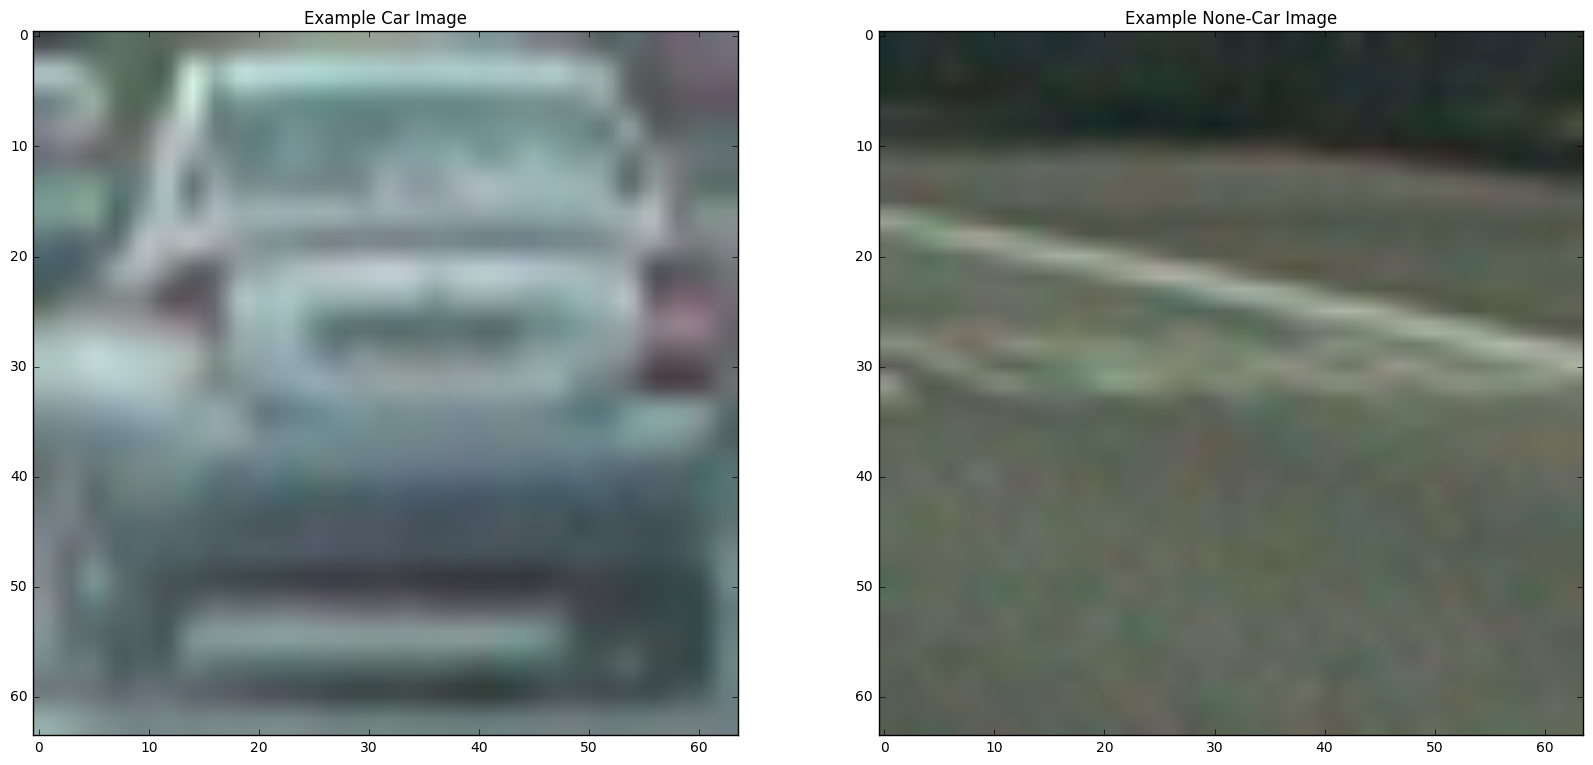

In [5]:
test_random_car_and_notcar(_cars, _notcars)

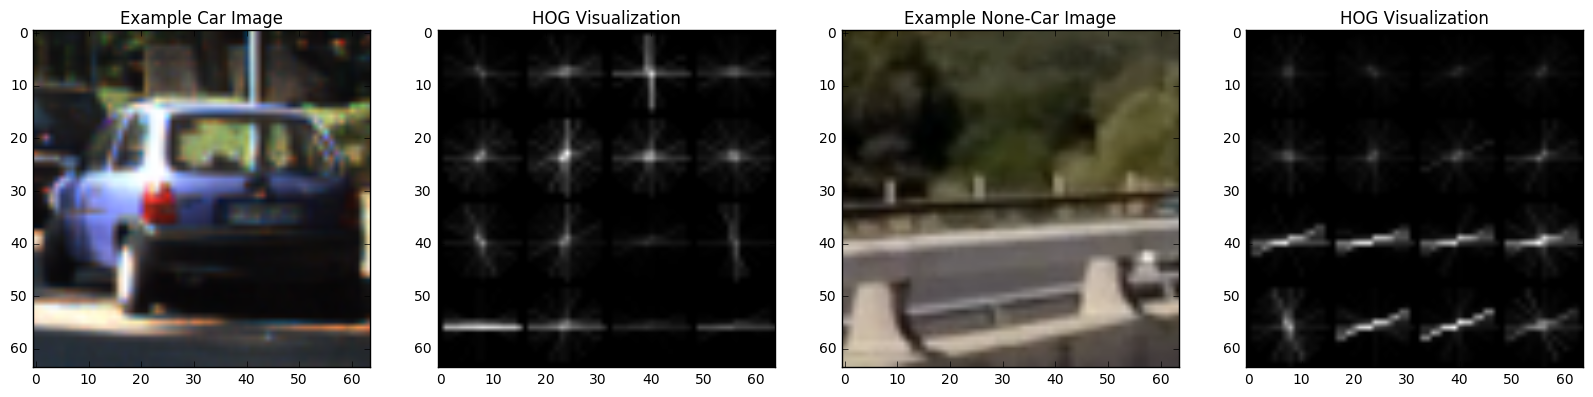

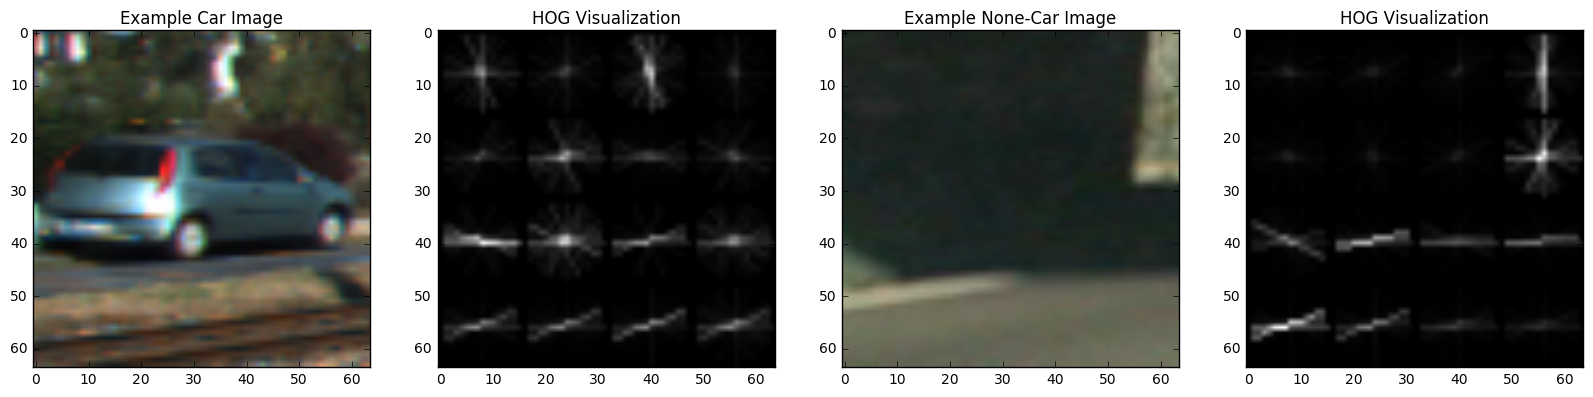

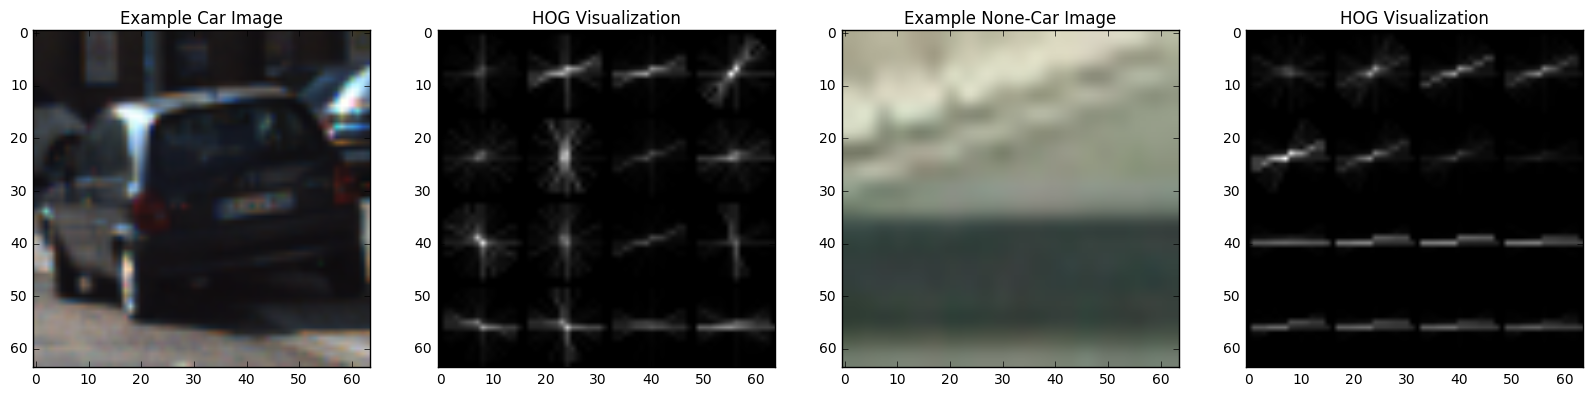

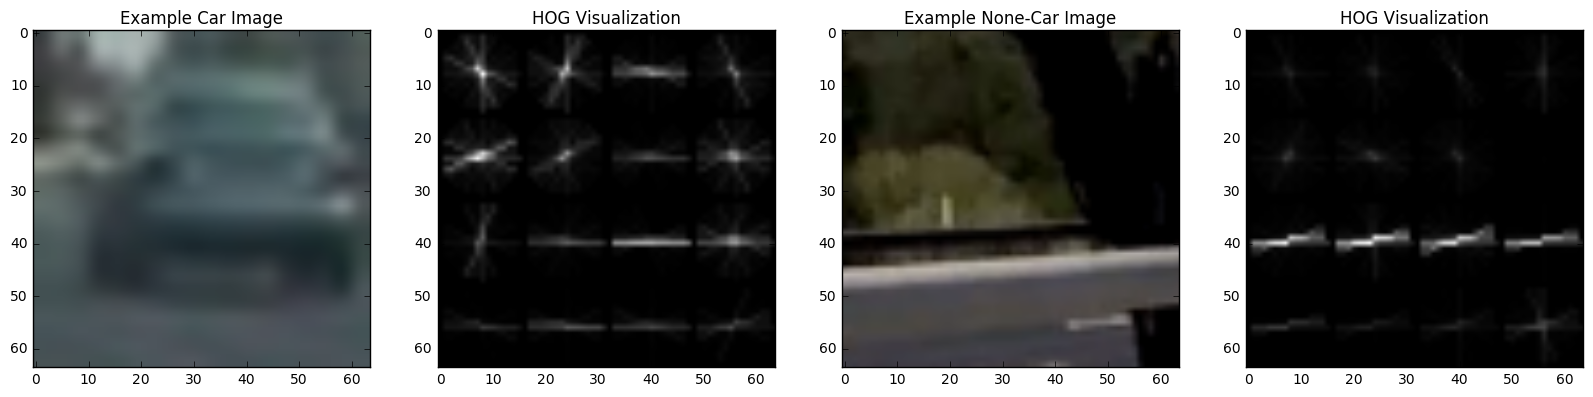

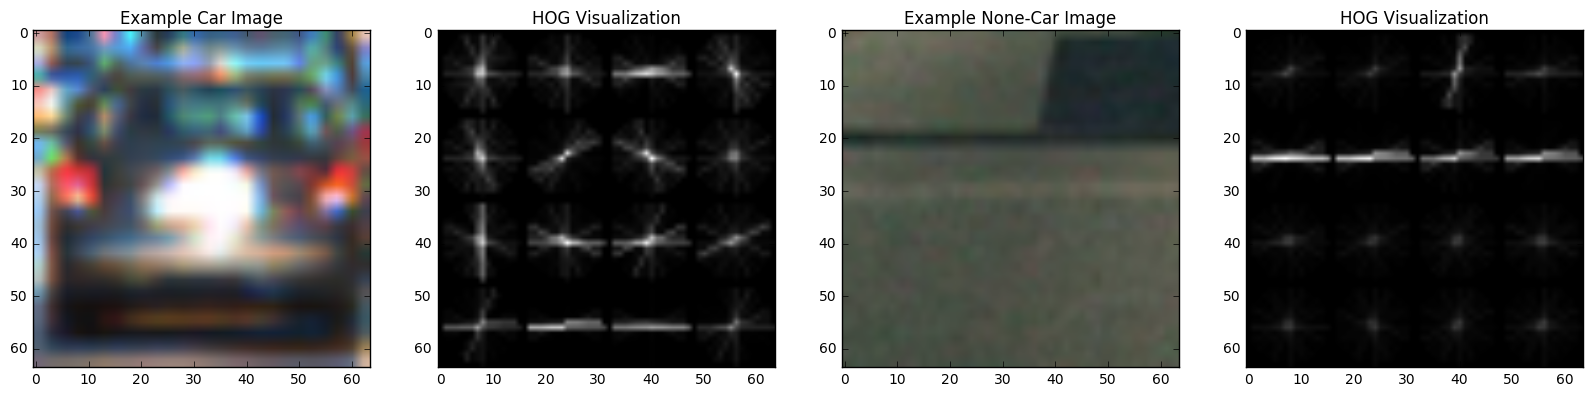

In [6]:
test_hog_random_car_and_notcar(_cars, _notcars, 5)

#### 2. Explain how you settled on your final choice of HOG parameters.

I tried many different variations of the HOG parameters and observed how the parameters impact the car detections. The default parameters suggested by Udacity worked well on training, but they performed not very well when detecting actual vehicles.

I ended up choosing this set of parameters:
- orient = 32
- pix_per_cell = 16
- cell_per_block = 2
- color_space = 'YCrCb'

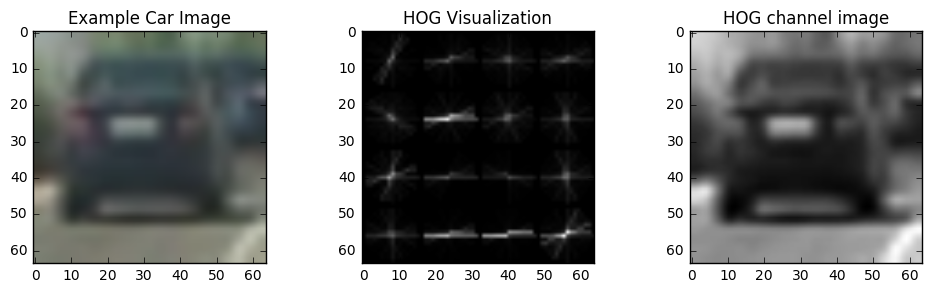

In [7]:
@interact
def test_hog(cars=fixed(_cars), i:(0, len(_cars))=0, orient:(0,32)=ORIENT, pix_per_cell:(8,24)=PIX_PER_CELL, cell_per_block:(1,4) = CELL_PER_BLOCK):
  
    img = mpimg.imread(cars[i])    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ycrcb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    
    features, hog_img = HogFeatureUtil.get_hog_features(gray, orient, 
                            pix_per_cell, cell_per_block, 
                            vis=True, feature_vec=False)

    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.imshow(img)
    plt.title('Example Car Image')
    plt.subplot(132)
    plt.imshow(hog_img, cmap='gray')
    plt.title('HOG Visualization')
    plt.subplot(133)
    plt.imshow(gray, cmap='gray')
    plt.title('HOG channel image')

#### 3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

I used LinearSVC as the classifier for this project. The code for the training is contained in the Trainer class (lib/trainer.py). In the Trainer.generate_train_and_test_data method, the features were generated using the HogFeatureUtil.extract_features method. Then, the train data was scaled using StandardScaler for normalization. The features includes the HOG feature and histogram features.

Once the training data was generated from the above steps, the training data has been passed to the Trainer.train method where the training data was randomly shuffled, split to the train and test data, and then the train data has been fit using LinearSVC instance.

The train was complete with 98.87% of accuracy, and the model was saved as "model.pkl" for a future use.

In [8]:
""" Train the model using SVM """
def train_model():
    global _X_scaler
    global _svc
    _X_scaler, X_train, y_train = Trainer.generate_train_and_test_data(_cars, _notcars, \
                orient=ORIENT, pix_per_cell=PIX_PER_CELL, cell_per_block=CELL_PER_BLOCK)
    _svc = LinearSVC()
    _svc = Trainer.train(_svc, X_train, y_train, TRAINED_MODEL_PATH)
    
train_model()

68.45 Seconds to extract HOG features...
Feature vector length: 3552
7.16 Seconds to train SVC...
Test Accuracy of SVC =  0.9896
My SVC predicts:  [ 1.  0.  1.  1.  0.  1.  0.  0.  1.  1.]
For these 10 labels:  [ 1.  0.  1.  1.  0.  1.  0.  0.  1.  1.]
0.00129 Seconds to predict 10 labels with SVC


In [9]:
# Load test images
test_images = VideoUtil.images_from_video('project_video.mp4')

100%|█████████▉| 1260/1261 [00:06<00:00, 209.72it/s]


In [10]:
def visualize_all_windows(svc, X_scaler, original_img):
    global _boxes_queue
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    img = original_img.astype(np.float32)/255   
    
    windows = VehicleDetector.get_windows(img.shape)
    windows_img = ImageUtil.draw_boxes(original_img, windows)
    fig = plt.figure(figsize=(12, 36))
    plt.subplot(131)
    plt.imshow(windows_img)
    

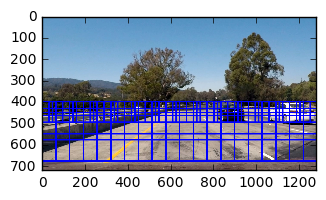

In [11]:
""" Visualize all available windows """
for fname in glob.glob(TEST_IMAGES_PATH):
    original_img = cv2.imread(fname)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    visualize_all_windows(_svc, _X_scaler, original_img)
    break

In [12]:
def visualize_find_cars(svc, X_scaler, original_img):
    global _boxes_queue
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    img = original_img.astype(np.float32)/255   
    
    windows = VehicleDetector.get_windows(img.shape)
    hot_windows = VehicleDetector.get_hot_windows(img, windows, svc, X_scaler, color_space=COLOR_SPACE,
                orient=ORIENT, pix_per_cell=PIX_PER_CELL, cell_per_block=CELL_PER_BLOCK)
    heat = VehicleDetector.find_heat(original_img, hot_windows, 1)
    heatmap_labels, heatmap = VehicleDetector.get_heatmap_labels(heat)

    # Draw result
    hot_windows_img = ImageUtil.draw_boxes(original_img, hot_windows)
    car_positions_img = ImageUtil.draw_boxes(original_img, heatmap_labels)     

    fig = plt.figure(figsize=(12, 36))
    plt.subplot(131)
    plt.imshow(hot_windows_img)
    plt.title('Detected boxes')
    plt.subplot(132)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    plt.subplot(133)
    plt.imshow(car_positions_img)
    plt.title('Car Positions')    
    fig.tight_layout() 

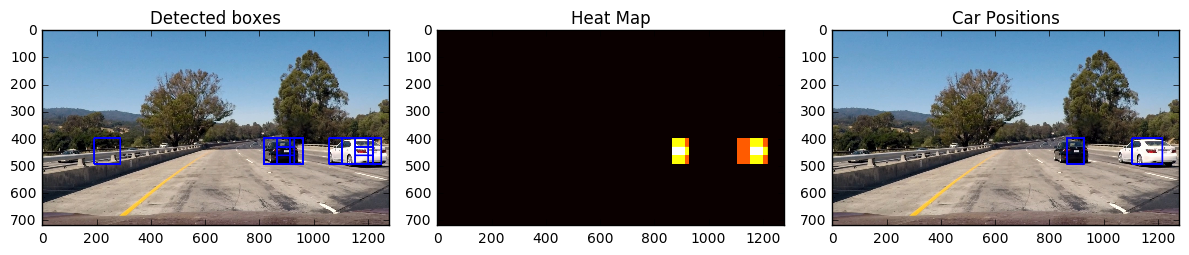

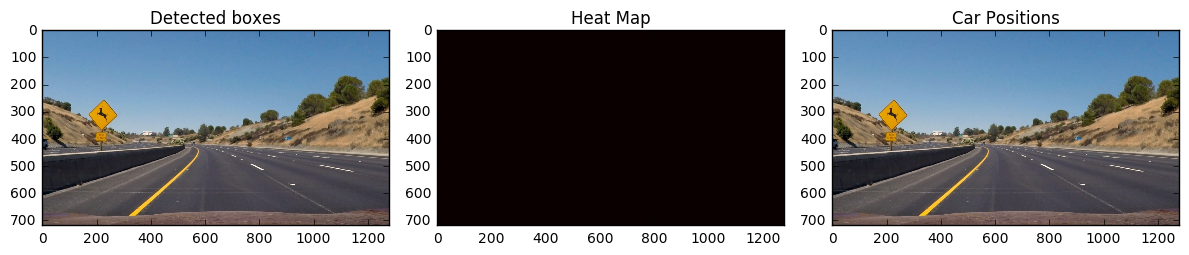

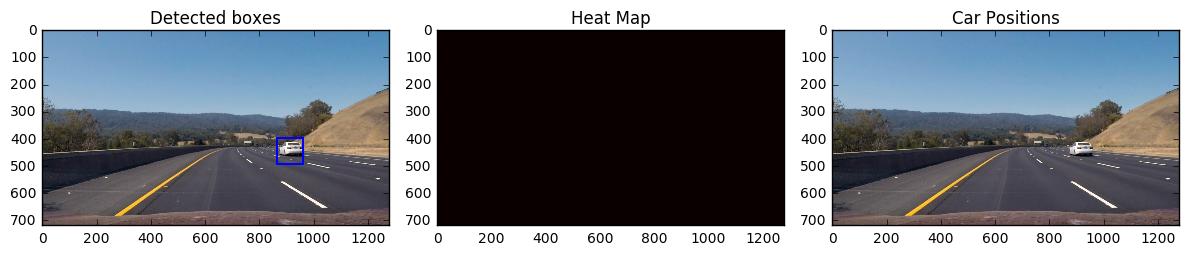

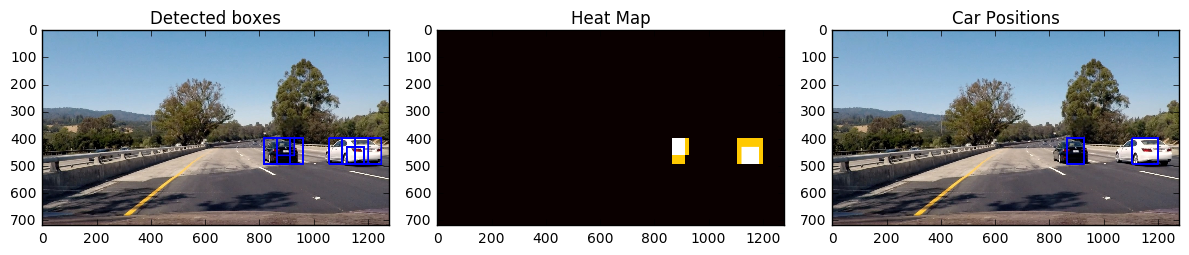

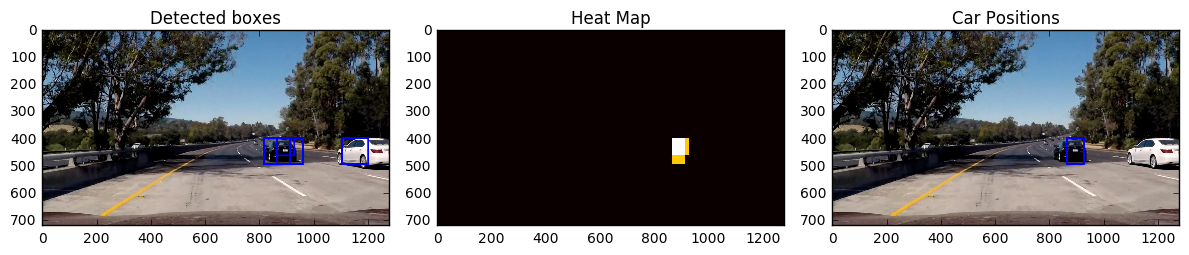

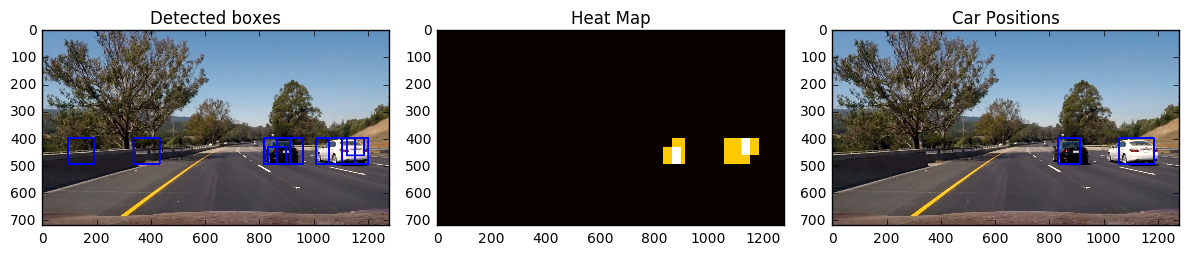

In [13]:
""" Visualize vehicle detection"""
for fname in glob.glob(TEST_IMAGES_PATH):
    original_img = cv2.imread(fname)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    visualize_find_cars(_svc, _X_scaler, original_img)

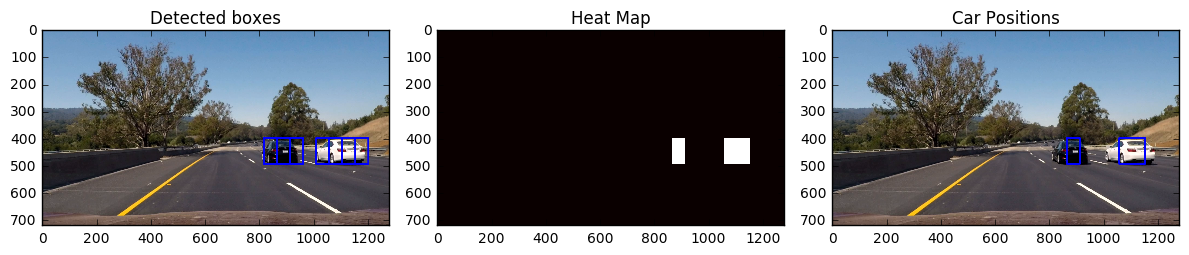

In [14]:
#init_process_video()

@interact
def test_find_cars(images=fixed(test_images), i:(0, len(test_images) - 1)=960):
    file, img = images[i]
    visualize_find_cars(_svc, _X_scaler, img)
    


In [43]:
def init_process_video():
    global _svc
    global _X_scaler
    global _boxes_queue
    
    """ Initialize global variables in preparation for processing image frames """
    _boxes_queue.clear()
    pass


def process_frame(frame_img):    
    global _boxes_queue

    img = frame_img.astype(np.float32)/255   
    
    windows = VehicleDetector.get_windows(img.shape)
    hot_windows = VehicleDetector.get_hot_windows(img, windows, _svc, _X_scaler, color_space=COLOR_SPACE,
                orient=ORIENT, pix_per_cell=PIX_PER_CELL, cell_per_block=CELL_PER_BLOCK)
    heat = VehicleDetector.find_heat(frame_img, hot_windows, 1)
    heatmap_labels, heatmap = VehicleDetector.get_heatmap_labels(heat)
    
    _boxes_queue.append(heatmap_labels)
    
    if len(_boxes_queue) > 5:
        # Generate the car position by averaging the previous frames
        boxes_list = []
        for boxes in _boxes_queue:
            if len(boxes) > 0:
                boxes_list.append(boxes[0])
        final_heat = VehicleDetector.find_heat(frame_img, boxes_list, 1)
        final_labels, heatmap = VehicleDetector.get_heatmap_labels(final_heat)

        # Draw result
        hot_windows_img = ImageUtil.draw_boxes(frame_img, hot_windows)
        car_positions_img = ImageUtil.draw_boxes(frame_img, final_labels)      
        return car_positions_img
    else
        return frame_img

In [42]:
if len(_boxes_queue) > 5:
    print('generating heatmap from queue!!!')
    boxes_list = []
    for boxes in _boxes_queue:
        if len(boxes) > 0:
            boxes_list.append(boxes[0])
    

generating heatmap from queue!!!


In [16]:
### Process Video

In [46]:
def processVideo(intput_file_name, output_file_name):    
    init_process_video()
    
    clip2 = VideoFileClip(intput_file_name)
    #clip2.subclip(frame_start=5, frame_end=15).speedx(2) # works
    clip_handler = clip2.fl_image(process_frame)
    %time clip_handler.write_videofile(output_file_name, audio=False)

In [ ]:
# Project video
processVideo('project_video.mp4', 'project_video_result.mp4')

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<11:56,  1.76it/s]

  0%|          | 2/1261 [00:01<12:07,  1.73it/s]

  0%|          | 3/1261 [00:01<11:59,  1.75it/s]

  0%|          | 4/1261 [00:02<12:26,  1.68it/s]

  0%|          | 5/1261 [00:02<12:27,  1.68it/s]

generating heatmap from queue!!!




  0%|          | 6/1261 [00:03<12:16,  1.70it/s]

generating heatmap from queue!!!




  1%|          | 7/1261 [00:04<12:18,  1.70it/s]

generating heatmap from queue!!!




  1%|          | 8/1261 [00:04<13:35,  1.54it/s]

generating heatmap from queue!!!




  1%|          | 9/1261 [00:05<13:07,  1.59it/s]

generating heatmap from queue!!!




  1%|          | 10/1261 [00:06<12:43,  1.64it/s]

generating heatmap from queue!!!




  1%|          | 11/1261 [00:06<12:35,  1.66it/s]

generating heatmap from queue!!!




  1%|          | 12/1261 [00:07<12:20,  1.69it/s]

generating heatmap from queue!!!




  1%|          | 13/1261 [00:07<12:09,  1.71it/s]

generating heatmap from queue!!!




  1%|          | 14/1261 [00:08<12:06,  1.72it/s]

generating heatmap from queue!!!




  1%|          | 15/1261 [00:08<12:00,  1.73it/s]

generating heatmap from queue!!!




  1%|▏         | 16/1261 [00:09<11:57,  1.74it/s]

generating heatmap from queue!!!




  1%|▏         | 17/1261 [00:10<11:55,  1.74it/s]

generating heatmap from queue!!!




  1%|▏         | 18/1261 [00:10<11:57,  1.73it/s]

generating heatmap from queue!!!




  2%|▏         | 19/1261 [00:11<11:53,  1.74it/s]

generating heatmap from queue!!!




  2%|▏         | 20/1261 [00:11<11:50,  1.75it/s]

generating heatmap from queue!!!




  2%|▏         | 21/1261 [00:12<11:44,  1.76it/s]

generating heatmap from queue!!!




  2%|▏         | 22/1261 [00:13<12:25,  1.66it/s]

generating heatmap from queue!!!




  2%|▏         | 23/1261 [00:13<13:08,  1.57it/s]

generating heatmap from queue!!!




  2%|▏         | 24/1261 [00:14<14:15,  1.45it/s]

generating heatmap from queue!!!




  2%|▏         | 25/1261 [00:15<13:40,  1.51it/s]

generating heatmap from queue!!!




  2%|▏         | 26/1261 [00:15<13:07,  1.57it/s]

generating heatmap from queue!!!




  2%|▏         | 27/1261 [00:16<12:47,  1.61it/s]

generating heatmap from queue!!!




  2%|▏         | 28/1261 [00:16<12:30,  1.64it/s]

generating heatmap from queue!!!




  2%|▏         | 29/1261 [00:17<12:16,  1.67it/s]

generating heatmap from queue!!!




  2%|▏         | 30/1261 [00:18<11:59,  1.71it/s]

generating heatmap from queue!!!




  2%|▏         | 31/1261 [00:18<11:56,  1.72it/s]

generating heatmap from queue!!!




  3%|▎         | 32/1261 [00:19<12:00,  1.71it/s]

generating heatmap from queue!!!




  3%|▎         | 33/1261 [00:19<11:54,  1.72it/s]

generating heatmap from queue!!!




  3%|▎         | 34/1261 [00:20<11:44,  1.74it/s]

generating heatmap from queue!!!




  3%|▎         | 35/1261 [00:20<11:39,  1.75it/s]

generating heatmap from queue!!!




  3%|▎         | 36/1261 [00:21<11:32,  1.77it/s]

generating heatmap from queue!!!




  3%|▎         | 37/1261 [00:22<11:35,  1.76it/s]

generating heatmap from queue!!!




  3%|▎         | 38/1261 [00:22<11:59,  1.70it/s]

generating heatmap from queue!!!




  3%|▎         | 39/1261 [00:23<13:20,  1.53it/s]

generating heatmap from queue!!!




  3%|▎         | 40/1261 [00:24<13:17,  1.53it/s]

generating heatmap from queue!!!




  3%|▎         | 41/1261 [00:24<13:03,  1.56it/s]

generating heatmap from queue!!!




  3%|▎         | 42/1261 [00:25<12:34,  1.61it/s]

generating heatmap from queue!!!




  3%|▎         | 43/1261 [00:25<12:26,  1.63it/s]

generating heatmap from queue!!!




  3%|▎         | 44/1261 [00:26<12:11,  1.66it/s]

generating heatmap from queue!!!




  4%|▎         | 45/1261 [00:27<12:04,  1.68it/s]

generating heatmap from queue!!!




  4%|▎         | 46/1261 [00:27<12:16,  1.65it/s]

generating heatmap from queue!!!




  4%|▎         | 47/1261 [00:28<12:21,  1.64it/s]

generating heatmap from queue!!!




  4%|▍         | 48/1261 [00:28<12:12,  1.66it/s]

generating heatmap from queue!!!




  4%|▍         | 49/1261 [00:29<12:04,  1.67it/s]

generating heatmap from queue!!!




  4%|▍         | 50/1261 [00:30<11:53,  1.70it/s]

generating heatmap from queue!!!




  4%|▍         | 51/1261 [00:30<11:41,  1.73it/s]

generating heatmap from queue!!!




  4%|▍         | 52/1261 [00:31<11:35,  1.74it/s]

generating heatmap from queue!!!




  4%|▍         | 53/1261 [00:31<11:38,  1.73it/s]

generating heatmap from queue!!!




  4%|▍         | 54/1261 [00:32<11:45,  1.71it/s]

generating heatmap from queue!!!




  4%|▍         | 55/1261 [00:33<12:10,  1.65it/s]

generating heatmap from queue!!!




  4%|▍         | 56/1261 [00:33<13:30,  1.49it/s]

generating heatmap from queue!!!




  5%|▍         | 57/1261 [00:34<14:37,  1.37it/s]

generating heatmap from queue!!!




  5%|▍         | 58/1261 [00:35<13:46,  1.45it/s]

generating heatmap from queue!!!




  5%|▍         | 59/1261 [00:35<13:23,  1.50it/s]

generating heatmap from queue!!!




  5%|▍         | 60/1261 [00:36<12:53,  1.55it/s]

generating heatmap from queue!!!




  5%|▍         | 61/1261 [00:37<12:27,  1.61it/s]

generating heatmap from queue!!!




  5%|▍         | 62/1261 [00:37<13:57,  1.43it/s]

generating heatmap from queue!!!




  5%|▍         | 63/1261 [00:38<13:29,  1.48it/s]

generating heatmap from queue!!!




  5%|▌         | 64/1261 [00:39<12:54,  1.55it/s]

generating heatmap from queue!!!




  5%|▌         | 65/1261 [00:39<12:25,  1.60it/s]

generating heatmap from queue!!!




  5%|▌         | 66/1261 [00:40<12:01,  1.66it/s]

generating heatmap from queue!!!




  5%|▌         | 67/1261 [00:40<11:43,  1.70it/s]

generating heatmap from queue!!!




  5%|▌         | 68/1261 [00:41<11:27,  1.74it/s]

generating heatmap from queue!!!




  5%|▌         | 69/1261 [00:41<11:16,  1.76it/s]

generating heatmap from queue!!!




  6%|▌         | 70/1261 [00:42<11:16,  1.76it/s]

generating heatmap from queue!!!




  6%|▌         | 71/1261 [00:43<11:30,  1.72it/s]

generating heatmap from queue!!!




  6%|▌         | 72/1261 [00:43<11:25,  1.74it/s]

generating heatmap from queue!!!




  6%|▌         | 73/1261 [00:44<11:34,  1.71it/s]

generating heatmap from queue!!!




  6%|▌         | 74/1261 [00:45<12:26,  1.59it/s]

generating heatmap from queue!!!




  6%|▌         | 75/1261 [00:45<12:52,  1.53it/s]

generating heatmap from queue!!!




  6%|▌         | 76/1261 [00:46<12:54,  1.53it/s]

generating heatmap from queue!!!




  6%|▌         | 77/1261 [00:47<12:45,  1.55it/s]

generating heatmap from queue!!!




  6%|▌         | 78/1261 [00:47<12:27,  1.58it/s]

generating heatmap from queue!!!




  6%|▋         | 79/1261 [00:48<12:13,  1.61it/s]

generating heatmap from queue!!!




  6%|▋         | 80/1261 [00:48<12:04,  1.63it/s]

generating heatmap from queue!!!




  6%|▋         | 81/1261 [00:49<12:01,  1.64it/s]

generating heatmap from queue!!!




  7%|▋         | 82/1261 [00:50<11:58,  1.64it/s]

generating heatmap from queue!!!




  7%|▋         | 83/1261 [00:50<11:52,  1.65it/s]

generating heatmap from queue!!!




  7%|▋         | 84/1261 [00:51<11:42,  1.68it/s]

generating heatmap from queue!!!




  7%|▋         | 85/1261 [00:51<11:36,  1.69it/s]

generating heatmap from queue!!!




  7%|▋         | 86/1261 [00:52<11:32,  1.70it/s]

generating heatmap from queue!!!




  7%|▋         | 87/1261 [00:52<11:34,  1.69it/s]

generating heatmap from queue!!!




  7%|▋         | 88/1261 [00:53<11:32,  1.69it/s]

generating heatmap from queue!!!




  7%|▋         | 89/1261 [00:54<11:34,  1.69it/s]

generating heatmap from queue!!!




  7%|▋         | 90/1261 [00:54<11:38,  1.68it/s]

generating heatmap from queue!!!




  7%|▋         | 91/1261 [00:55<11:39,  1.67it/s]

generating heatmap from queue!!!




  7%|▋         | 92/1261 [00:55<11:35,  1.68it/s]

generating heatmap from queue!!!




  7%|▋         | 93/1261 [00:56<11:36,  1.68it/s]

generating heatmap from queue!!!




  7%|▋         | 94/1261 [00:57<11:38,  1.67it/s]

generating heatmap from queue!!!




  8%|▊         | 95/1261 [00:57<11:41,  1.66it/s]

generating heatmap from queue!!!




  8%|▊         | 96/1261 [00:58<11:35,  1.68it/s]

generating heatmap from queue!!!




  8%|▊         | 97/1261 [00:58<11:55,  1.63it/s]

generating heatmap from queue!!!




  8%|▊         | 98/1261 [00:59<11:45,  1.65it/s]

generating heatmap from queue!!!




  8%|▊         | 99/1261 [01:00<11:36,  1.67it/s]

generating heatmap from queue!!!




  8%|▊         | 100/1261 [01:00<11:37,  1.66it/s]

generating heatmap from queue!!!




  8%|▊         | 101/1261 [01:01<11:47,  1.64it/s]

generating heatmap from queue!!!




  8%|▊         | 102/1261 [01:01<11:32,  1.67it/s]

generating heatmap from queue!!!




  8%|▊         | 103/1261 [01:02<11:27,  1.68it/s]

generating heatmap from queue!!!




  8%|▊         | 104/1261 [01:03<11:17,  1.71it/s]

generating heatmap from queue!!!




  8%|▊         | 105/1261 [01:03<11:08,  1.73it/s]

generating heatmap from queue!!!




  8%|▊         | 106/1261 [01:04<11:02,  1.74it/s]

generating heatmap from queue!!!




  8%|▊         | 107/1261 [01:04<10:59,  1.75it/s]

generating heatmap from queue!!!




  9%|▊         | 108/1261 [01:05<10:58,  1.75it/s]

generating heatmap from queue!!!




  9%|▊         | 109/1261 [01:05<10:55,  1.76it/s]

generating heatmap from queue!!!




  9%|▊         | 110/1261 [01:06<10:52,  1.76it/s]

generating heatmap from queue!!!




  9%|▉         | 111/1261 [01:07<11:01,  1.74it/s]

generating heatmap from queue!!!




  9%|▉         | 112/1261 [01:07<11:04,  1.73it/s]

generating heatmap from queue!!!




  9%|▉         | 113/1261 [01:08<11:15,  1.70it/s]

generating heatmap from queue!!!




  9%|▉         | 114/1261 [01:08<11:24,  1.68it/s]

generating heatmap from queue!!!




  9%|▉         | 115/1261 [01:09<11:18,  1.69it/s]

generating heatmap from queue!!!




  9%|▉         | 116/1261 [01:10<11:09,  1.71it/s]

generating heatmap from queue!!!




  9%|▉         | 117/1261 [01:10<11:04,  1.72it/s]

generating heatmap from queue!!!




  9%|▉         | 118/1261 [01:11<11:06,  1.72it/s]

generating heatmap from queue!!!




  9%|▉         | 119/1261 [01:11<10:59,  1.73it/s]

generating heatmap from queue!!!




 10%|▉         | 120/1261 [01:12<11:00,  1.73it/s]

generating heatmap from queue!!!




 10%|▉         | 121/1261 [01:12<10:59,  1.73it/s]

generating heatmap from queue!!!




 10%|▉         | 122/1261 [01:13<10:50,  1.75it/s]

generating heatmap from queue!!!




 10%|▉         | 123/1261 [01:14<10:49,  1.75it/s]

generating heatmap from queue!!!




 10%|▉         | 124/1261 [01:14<10:44,  1.77it/s]

generating heatmap from queue!!!




 10%|▉         | 125/1261 [01:15<10:45,  1.76it/s]

generating heatmap from queue!!!




 10%|▉         | 126/1261 [01:15<11:59,  1.58it/s]

generating heatmap from queue!!!




 10%|█         | 127/1261 [01:16<11:37,  1.63it/s]

generating heatmap from queue!!!




 10%|█         | 128/1261 [01:17<11:20,  1.66it/s]

generating heatmap from queue!!!




 10%|█         | 129/1261 [01:17<11:09,  1.69it/s]

generating heatmap from queue!!!




 10%|█         | 130/1261 [01:18<11:05,  1.70it/s]

generating heatmap from queue!!!




 10%|█         | 131/1261 [01:18<11:02,  1.71it/s]

generating heatmap from queue!!!




 10%|█         | 132/1261 [01:19<11:00,  1.71it/s]

generating heatmap from queue!!!




 11%|█         | 133/1261 [01:20<10:58,  1.71it/s]

generating heatmap from queue!!!




 11%|█         | 134/1261 [01:20<11:00,  1.71it/s]

generating heatmap from queue!!!




 11%|█         | 135/1261 [01:21<11:01,  1.70it/s]

generating heatmap from queue!!!




 11%|█         | 136/1261 [01:21<10:58,  1.71it/s]

generating heatmap from queue!!!




 11%|█         | 137/1261 [01:22<11:25,  1.64it/s]

generating heatmap from queue!!!




 11%|█         | 138/1261 [01:23<11:47,  1.59it/s]

generating heatmap from queue!!!




 11%|█         | 139/1261 [01:23<11:35,  1.61it/s]

generating heatmap from queue!!!




 11%|█         | 140/1261 [01:24<11:27,  1.63it/s]

generating heatmap from queue!!!




 11%|█         | 141/1261 [01:24<11:20,  1.64it/s]

generating heatmap from queue!!!




 11%|█▏        | 142/1261 [01:25<11:15,  1.66it/s]

generating heatmap from queue!!!




 11%|█▏        | 143/1261 [01:26<11:14,  1.66it/s]

generating heatmap from queue!!!




 11%|█▏        | 144/1261 [01:26<11:09,  1.67it/s]

generating heatmap from queue!!!




 11%|█▏        | 145/1261 [01:27<11:06,  1.67it/s]

generating heatmap from queue!!!




 12%|█▏        | 146/1261 [01:27<11:00,  1.69it/s]

generating heatmap from queue!!!




 12%|█▏        | 147/1261 [01:28<10:50,  1.71it/s]

generating heatmap from queue!!!




 12%|█▏        | 148/1261 [01:28<10:38,  1.74it/s]

generating heatmap from queue!!!




 12%|█▏        | 149/1261 [01:29<10:31,  1.76it/s]

generating heatmap from queue!!!




 12%|█▏        | 150/1261 [01:30<10:25,  1.78it/s]

generating heatmap from queue!!!




 12%|█▏        | 151/1261 [01:30<10:20,  1.79it/s]

generating heatmap from queue!!!




 12%|█▏        | 152/1261 [01:31<10:16,  1.80it/s]

generating heatmap from queue!!!




 12%|█▏        | 153/1261 [01:31<10:14,  1.80it/s]

generating heatmap from queue!!!




 12%|█▏        | 154/1261 [01:32<10:12,  1.81it/s]

generating heatmap from queue!!!




 12%|█▏        | 155/1261 [01:32<10:13,  1.80it/s]

generating heatmap from queue!!!




 12%|█▏        | 156/1261 [01:33<10:11,  1.81it/s]

generating heatmap from queue!!!


In [ ]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format("project_video_result.mp4"))

[//]: # (Image References)
[image1]: ./examples/car_not_car.png
[image2]: ./examples/HOG_example.jpg
[image3]: ./examples/sliding_windows.jpg
[image4]: ./examples/sliding_window.jpg
[image5]: ./examples/bboxes_and_heat.png
[image6]: ./examples/labels_map.png
[image7]: ./examples/output_bboxes.png
[video1]: ./project_video.mp4

[img_heatmaps]: ./output_images/heatmaps.png


### Video Implementation

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)
Here's a [link to my video result](./project_video.mp4)


#### 2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

For each frame, I captured the positions of the positive detections in a deque. Once the deque hold 10 positive detections, I generated the heatmap using the deque, and used the scipy.ndimage.measurements.label() method to generate the final positions.

### Here are six frames and their corresponding heatmaps:

![alt text][img_heatmaps]



---

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Initially, I encountered the problems where the detected position of vehicles was jumping around for each frame with some false positives. I resolved this issue by storing the deteced position of vehicles to a queue, and generating the final position of vehicles by averaging the accumulated positions through heatmap and label technique.

The pipeline may fail if the application encounters the following scenarios:
- A strangely looking vehicle that does not look similiar to train data.
- Shadow or poor weather condition that createa 

I can further improve the application by the following actions:
- Enhancing the training dataset to contain more diverse vehicle images and non-vehicle images. 
- Adjust the HOG parameters further to maximize the positive detections
 